<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/res-Copy_of_pantompskin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [ ]:
!wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [7]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [8]:
import sys

import numpy as np
from scipy import signal, ndimage

In [9]:
def pan_tompkins(input_signal, sampling_frequency, low, high):
    filtered_singal = bandpass_filter(input_signal, low, high,sampling_frequency)
    moving_avg = moving_window_integration(squaring(derivative(filtered_singal, sampling_frequency
                                            )), int(0.15*sampling_frequency))
    moving_avg[: int(0.2 * sampling_frequency)] = 0
    peaks = detect_peaks(moving_avg, sampling_frequency)

    return peaks

def detect_peaks(detection, sampling_rate=1000, **kwargs):
    """Based on https://github.com/berndporr/py-ecg-detectors/
    Optimized for vectorized computation.
    """
    min_peak_distance = int(0.3 * sampling_rate)
    min_missed_distance = int(0.25 * sampling_rate)

    signal_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    last_peak = 0
    last_index = -1

    peaks, _ = signal.find_peaks(detection, plateau_size=(1, 1))
    for index, peak in enumerate(peaks):
        peak_value = detection[peak]

        threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
        if peak_value > threshold_I1 and peak > last_peak + min_peak_distance:
            signal_peaks.append(peak)

            # RR_missed threshold is based on the previous eight R-R intervals
            if len(signal_peaks) > 9:
                RR_ave = (signal_peaks[-2] - signal_peaks[-10]) // 8
                RR_missed = int(1.66 * RR_ave)
                if peak - last_peak > RR_missed:
                    missed_peaks = peaks[last_index + 1 : index]
                    missed_peaks = missed_peaks[
                        (missed_peaks > last_peak + min_missed_distance)
                        & (missed_peaks < peak - min_missed_distance)
                    ]
                    threshold_I2 = 0.5 * threshold_I1
                    missed_peaks = missed_peaks[detection[missed_peaks] > threshold_I2]
                    if len(missed_peaks) > 0:
                        signal_peaks[-1] = missed_peaks[np.argmax(detection[missed_peaks])]
                        signal_peaks.append(peak)

            last_peak = peak
            last_index = index

            SPKI = 0.125 * peak_value + 0.875 * SPKI
        else:
            NPKI = 0.125 * peak_value + 0.875 * NPKI

    return signal_peaks

def moving_window_integration(signal, window_size):
    window_size = int(window_size)

    mwa = ndimage.uniform_filter1d(signal, window_size, origin=(window_size - 1) // 2)

    head_size = min(window_size - 1, len(signal))
    mwa[:head_size] = np.cumsum(signal[:head_size]) / np.linspace(1, head_size, head_size)
    return mwa

def squaring(input_signal):
    return np.square(input_signal)

def derivative(input_signal, sampled_frequency):
    return derivative_difference_equation(input_signal, sampled_frequency)

def bandpass_filter(input_signal, low, high, sampling_freq):
    return highpass_filter(lowpass_filter(input_signal, high, sampling_freq), low, sampling_freq)

def lowpass_filter(input_signal, cutoff, sampling_freq):
    return low_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def highpass_filter(input_signal, cutoff, sampling_freq):
    return high_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def derivative_numpy(input_signal, sampling_frequency):
    return np.diff(input_signal)

# y(n) = (1/8)*T 
#        *[-x(n-2) -2*x(n-1) +2x(n+1) +x(n+2)]
def derivative_difference_equation(input_signal, sampled_frequency):
    derived_signal = input_signal.copy()
    for index in range(len(input_signal)):
        derived_sample = derived_signal[index]
        if (index >= 2): derived_sample -= input_signal[index-2]
        if (index >= 1): derived_sample -= 2*input_signal[index-1]
        
        if (index < len(input_signal)-1): derived_sample += 2*input_signal[index+1]
        if (index < len(input_signal)-2): derived_sample += input_signal[index+2]
    
    derived_signal = derived_signal / ((1/8)*(1/sampled_frequency))
    return derived_signal

def low_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(2, cutoff_freq/(sampling_freq/2), 'low', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

def high_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(1, cutoff_freq/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

## Run Method

In [ ]:
! pip install neurokit2
import neurokit2 as nk2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00


In [ ]:
def get_peaks(sample_path, leads, fs):
    signal, rest = wfdb.rdsamp(sample_path, sampfrom=0, sampto=None, 
                                channel_names = leads)
    cleaned = nk2.ecg_clean(signal, fs, method='pantompkins1985')
    signals, info = nk2.ecg_peaks(cleaned, fs, method='pantompkins1985')

    return info["ECG_R_Peaks"]

## Low pass methods

In [ ]:
spath = '/content/physionet.org/files/nsrdb/1.0.0/16272'
print('Clean Signal')
peaks, real_peaks = run_pantompkins(spath, 'ECG1', 5, 11, 360, 3000)
evaluation(peaks, real_peaks, int(150/(1000/360)))

## Run on Whole Dataset

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
arr = os.listdir('/content/physionet.org/files/nsrdb/1.0.0')

sample_ids = []
for file in arr:
    if '.atr' in file:
      current_id = int(file[:5])
      if current_id not in sample_ids:
        sample_ids.append(current_id)
sample_ids.sort()
        

In [ ]:
root_folder = '/content/physionet.org/files/nsrdb/1.0.0/'
sensitivity = []
ppv = []
f1 = []


In [ ]:
for id in sample_ids:
  for lead in ['ECG1', 'ECG2']:
    
    sample_path = root_folder + str(id)
    peaks = get_peaks(sample_path, [lead], 128)
    annots = wfdb.rdann(sample_path, 'atr', sampfrom=0, sampto=None)

    model_save_name = str(id)+'-'+lead+'.npz'
    path = F"/content/gdrive/My Drive/2peaks/{model_save_name}" 
    np.savez(path, detected = peaks, ref = annots.sample)

    print(id, lead)

16265 ECG1
16265 ECG2
16272 ECG1
16272 ECG2
16273 ECG1
16273 ECG2
16420 ECG1
16420 ECG2
16483 ECG1
16483 ECG2
16539 ECG1
16539 ECG2
16773 ECG1
16773 ECG2
16786 ECG1
16786 ECG2
16795 ECG1
16795 ECG2
17052 ECG1
17052 ECG2
17453 ECG1
17453 ECG2
18177 ECG1
18177 ECG2
18184 ECG1
18184 ECG2
19088 ECG1
19088 ECG2
19090 ECG1
19090 ECG2
19093 ECG1
19093 ECG2
19140 ECG1
19140 ECG2
19830 ECG1
19830 ECG2


In [12]:
def evaluation(peaks, real_peaks, interval):
    check_peaks = peaks.copy()
    n_ref = len(real_peaks[1:])
    n_detected = len(peaks)
    count = 0
    for i in range(n_ref):
        correct = real_peaks[1:][i]
        condition = (check_peaks>=correct-interval) & (check_peaks<=correct+interval)
        found = np.array(check_peaks)[condition]
        if len(found) >= 1:
          for f in found:
            check_peaks.remove(f)
          count += 1
    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": str(sensitivity*100)+'%',
              'PPV': str(ppv*100)+'%',
              'F1': str(f1*100) + '%'
              }
    return result

In [1]:
import pandas as pd

In [ ]:
df_sen = pd.DataFrame(0.0, index=sample_ids, columns=['ECG1', 'ECG2'])
df_ppv = pd.DataFrame(0.0, index=sample_ids, columns=['ECG1', 'ECG2'])
df_f1 = pd.DataFrame(0.0, index=sample_ids, columns=['ECG1', 'ECG2'])

In [13]:
df_sen = pd.read_csv("/content/gdrive/My Drive/2peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/2peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/2peaks/f1.csv" )

df_ppv.set_index('Unnamed: 0')
df_sen.set_index('Unnamed: 0')
df_f1.set_index('Unnamed: 0')

,ECG1,ECG2
Unnamed: 0,,
16265,99.765185,99.644795
16272,35.998264,33.175891
16273,99.857727,99.843316
16420,99.827898,99.800536
16483,99.892774,99.892773
16539,99.818861,99.809648
16773,84.140309,84.141555
16786,99.947879,99.914454
16795,99.548605,99.545179


In [14]:
for id in sample_ids[10:15]:

  for lead in ['ECG1', 'ECG2']:
    model_save_name = str(id)+'-'+lead+'.npz'
    path = F"/content/gdrive/My Drive/2peaks/{model_save_name}" 
    saved = np.load(path, allow_pickle=True)
    peaks = list(saved['detected'])
    real_peaks = list(saved['ref'])
    res = evaluation(peaks, real_peaks, int(150/(1000/128)))
    df_sen.loc[id, lead] = float(res['sensitivity'][0:-1])
    df_ppv.loc[id, lead] = float(res['PPV'][0:-1])
    df_f1.loc[id, lead] = float(res['F1'][0:-1])

    df_sen.to_csv("/content/gdrive/My Drive/2peaks/sen.csv" )
    df_ppv.to_csv("/content/gdrive/My Drive/2peaks/ppv.csv" )
    df_f1.to_csv("/content/gdrive/My Drive/2peaks/f1.csv" )

In [15]:
df_ppv

,Unnamed: 0,ECG1,ECG2
0,16265.0,100.000000,99.810177
1,16272.0,95.084424,98.291335
2,16273.0,100.000000,99.961061
3,16420.0,99.994123,99.957890
4,16483.0,99.996167,99.997125
5,16539.0,99.996306,99.984302
6,16773.0,100.000000,99.995122
7,16786.0,99.999016,99.951801
8,16795.0,99.997698,99.991944
9,17052.0,99.997716,99.970312


In [ ]:
df_sen.to_csv("/content/gdrive/My Drive/2peaks/sen.csv" )
df_ppv.to_csv("/content/gdrive/My Drive/2peaks/ppv.csv" )
df_f1.to_csv("/content/gdrive/My Drive/2peaks/f1.csv" )

In [ ]:
df_sen = pd.read_csv("/content/gdrive/My Drive/3peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/3peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/3peaks/f1.csv" )

In [ ]:
df_sen

,Unnamed: 0,Unnamed: 0.1,ECG1,ECG2
0,0,18177.0,99.305146,99.308565
1,1,16773.0,72.621705,72.626134
2,2,16483.0,99.780987,99.780031
3,3,19140.0,99.817509,99.796888
4,4,18184.0,99.710726,0.000000
5,5,17052.0,0.000000,0.000000
6,6,16795.0,0.000000,0.000000
7,7,19090.0,0.000000,0.000000
8,8,17453.0,0.000000,0.000000
9,9,16420.0,0.000000,0.000000


In [ ]:
np.average(df_sen['ECG1']), np.average(df_ppv['ECG1']), np.average(df_f1[ 'ECG1'])

(91.70034828436637, 99.864941706209, 94.1523959953412)

In [ ]:
np.average(df_sen['ECG2']), np.average(df_ppv['ECG2']), np.average(df_f1[ 'ECG2'])

(91.70034828436637, 99.864941706209, 94.1523959953412)

In [ ]:
def to_float(arr):
    ret = []
    for x in arr:
        ret.append(float(x[0:-1]))
    return ret 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

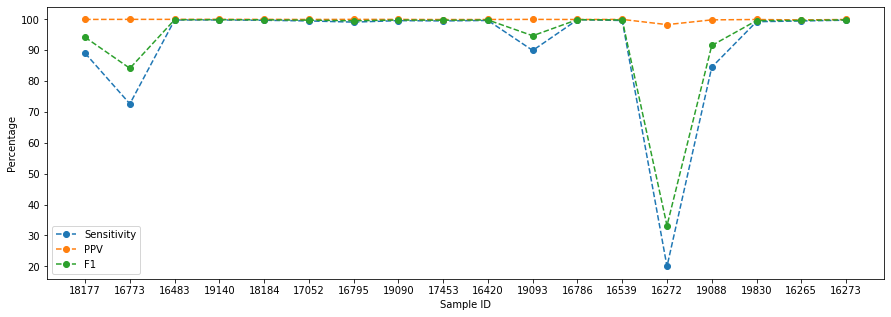

In [ ]:
plt.figure(figsize=(15,5))
plt.xlabel('Sample ID')
plt.ylabel('Percentage')

plt.plot(sample_ids, df_sen['ECG1'], label='Sensitivity', marker='o', linestyle='--')
plt.plot(sample_ids, df_ppv['ECG1'], label='PPV', marker='o', linestyle='--')
plt.plot(sample_ids, df_f1[ 'ECG1'], label='F1', marker='o', linestyle='--')

plt.legend()

In [ ]:
np.average(to_float(sensitivity)), np.average(to_float(ppv)), np.average(to_float(f1))

(88.70252930995336, 94.52263293614219, 90.48624490723604)